In [1]:
import platform
import os
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import mmh3
import random
from collections import defaultdict
from BasicFunc import gen_rand_seed, gen_hash, SpreadCollection, actual_relative_error
from BasicFunc import is_valid_ipv4_address, ip_addr_to_int
from tqdm import tqdm

In [2]:
max_priority = 7
mea_T = 0
color_table = ['red', 'green', 'blue', 'c', 'pink', 'purple', 'orange', 'crimson', 'skyblue', 'chocolate', 'violet', 'navy']
color_lst = [color_table[i] for i in range(max_priority)]
high_prior_flows = set([6,7])
mediumn_prior_flows = set([])
low_prior_flows = set([1,2,3,4,5])

In [3]:
class vhll():

    def __init__(self, num_phy_registers, num_registers_for_vhll):
        self.num_phy_registers = num_phy_registers
        self.num_registers_for_vhll = num_registers_for_vhll

        distinct_seeds = set()
        while len(distinct_seeds) < num_registers_for_vhll:
            seed_t = gen_rand_seed()
            if seed_t not in distinct_seeds:
                distinct_seeds.add(seed_t)
        self.seeds = list(distinct_seeds)
        self.range_for_seed_index = math.floor(math.log(self.num_registers_for_vhll, 2))
        self.hash_seed = gen_rand_seed()

        self.phy_registers = [0 for i in range(num_phy_registers)]
        self.flows = set()

        self.spread_of_all_flows = 0
        self.alpha = 0
        if self.num_registers_for_vhll == 16:
            self.alpha = 0.673
        elif self.num_registers_for_vhll == 32:
            self.alpha = 0.697
        elif self.num_registers_for_vhll == 64:
            self.alpha = 0.709
        else:
            self.alpha = (0.7213 / (1 + (1.079 / self.num_registers_for_vhll)))

    def set(self, flow_id, ele_id):
        self.flows.add(flow_id)

        ele_hash_value = gen_hash(ele_id, self.hash_seed)
        p_part = ele_hash_value >> (32 - self.range_for_seed_index)
        q_part = ele_hash_value - (p_part << (32 - self.range_for_seed_index))

        leftmost_index = 0
        while q_part:
            leftmost_index += 1
            q_part >>= 1
        leftmost_index = 32 - self.range_for_seed_index - leftmost_index + 1

        index_for_register = gen_hash(flow_id ^ self.seeds[p_part], self.hash_seed) % self.num_phy_registers
        self.phy_registers[index_for_register] = max(self.phy_registers[index_for_register], leftmost_index)

    def update_para(self):
        fraction_zeros = 0
        sum_registers = 0
        for register in self.phy_registers:
            sum_registers += 2 ** (-register)
            if register == 0:
                fraction_zeros += 1
        fraction_zeros = fraction_zeros / self.num_phy_registers
        spread_of_all_flows = (0.7213 / (1 + (1.079 / self.num_phy_registers))) * (
                    self.num_phy_registers ** 2) / sum_registers
        if spread_of_all_flows < 2.5 * self.num_phy_registers:
            if fraction_zeros != 0:
                self.spread_of_all_flows = - self.num_phy_registers * math.log(fraction_zeros)
        elif spread_of_all_flows > 2 ** 32 / 30:
            self.spread_of_all_flows = - 2 ** 32 * math.log(1 - spread_of_all_flows / 2 ** 32)

    def estimate(self, flow_id):
        fraction_zeros_for_vhll = 0
        sum_registers_for_vhll = 0
        for seed in self.seeds:
            index_for_vhll = gen_hash(flow_id ^ seed, self.hash_seed) % self.num_phy_registers
            sum_registers_for_vhll += 2 ** (- self.phy_registers[index_for_vhll])
            if self.phy_registers[index_for_vhll] == 0:
                fraction_zeros_for_vhll += 1
        fraction_zeros_for_vhll = fraction_zeros_for_vhll / self.num_registers_for_vhll
        spread_of_the_flow = self.alpha * (self.num_registers_for_vhll ** 2) / sum_registers_for_vhll

        if spread_of_the_flow < 2.5 * self.num_registers_for_vhll:
            if fraction_zeros_for_vhll != 0:
                spread_of_the_flow = - self.num_registers_for_vhll * math.log(fraction_zeros_for_vhll) - \
                                 (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)
            else:
                spread_of_the_flow = spread_of_the_flow - \
                                     (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)
        elif spread_of_the_flow > 2 ** 32 / 30:
            spread_of_the_flow = - 2 ** 32 * math.log(1 - spread_of_the_flow / 2 ** 32) - \
                                 (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)
        else:
            spread_of_the_flow = spread_of_the_flow - \
                                 (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)

        return spread_of_the_flow

    def get_all_spread(self):
        self.update_para()
        all_spread = {}
        for flow_id in tqdm(self.flows):
            all_spread[flow_id] = self.estimate(flow_id)
            # print(all_spread[flow_id])
        return all_spread

In [4]:
fo = open("./CAIDA 2016/00_7.txt", "r")
flows = fo.readlines()
fo.close()

In [5]:
num_registers_for_vhll = 8
num_phy_registers = int(50 * 2 ** 13 / 5)
vhll_instance = vhll(num_phy_registers, num_registers_for_vhll)

In [6]:
print(num_phy_registers)

81920


In [7]:
num_bits_for_register = math.ceil(math.log(32 - math.log(num_registers_for_vhll, 2), 2))

In [8]:
sss1 = 12
sss2 = 21
f_p_table = defaultdict(int)
for item in flows:
    f, e, p = item.strip().split()
    p = int(p)
    f_p_table[f] = p
    f = mmh3.hash(f, sss1)
    e = mmh3.hash(e, sss2)
    vhll_instance.set(f, e)

In [9]:
estimation = vhll_instance.get_all_spread()

100%|██████████| 589709/589709 [00:05<00:00, 117511.17it/s]


In [10]:
flows_info = defaultdict(list)

for item in flows:
    f, e, p = item.strip().split()
    flows_info[f].append(e)

In [11]:
spread_info = dict()

for f in flows_info.keys():
    spread_info[f] = len(set(flows_info[f]))

In [12]:
x_dict = {}
y_dict = {}
x = []
y = []
range_count_dict = {}
range_are_dict = {}
are_dict = {}
are_count_dict = {}
for i in range(1, max_priority + 1):
    x_dict[i] = []
    y_dict[i] = []
    are_dict[i] = 0
    are_count_dict[i] = 0
    range_count_dict[i] = {}
    range_are_dict[i] = {}
    for j in range(0, 7, 1):
        range_count_dict[i][j] = 0
        range_are_dict[i][j] = 0
class_are_dict = {'low':0, 'med':0, 'high':0}
flow_count_p = {'low':0, 'med':0, 'high':0}
for f in flows_info.keys():
    if spread_info[f] >= mea_T:
        temp_v = abs(spread_info[f] - estimation[mmh3.hash(f, sss1)]) / spread_info[f]
        x.append(spread_info[f])
        y.append(estimation[mmh3.hash(f,sss1)])
        x_dict[f_p_table[f]].append(spread_info[f])
        range_count_dict[f_p_table[f]][int(round(np.log10(spread_info[f])))] += 1
        y_dict[f_p_table[f]].append(estimation[mmh3.hash(f, sss1)])
        range_are_dict[f_p_table[f]][int(round(np.log10(spread_info[f])))] += temp_v
        are_count_dict[f_p_table[f]] += 1
        are_dict[f_p_table[f]] += temp_v
        if f_p_table[f] in high_prior_flows:
            class_are_dict['high'] += temp_v
            flow_count_p['high'] += 1
        elif f_p_table[f] in mediumn_prior_flows:
            class_are_dict['med'] += temp_v
            flow_count_p['med'] += 1
        elif f_p_table[f] in low_prior_flows:
            class_are_dict['low'] += temp_v
            flow_count_p['low'] += 1
for i in range(1, max_priority + 1):
    for j in range(max_priority):
        range_are_dict[i][j] = range_are_dict[i][j] / range_count_dict[i][j] if range_count_dict[i][j] != 0 else None
class_are_dict['high'] = class_are_dict['high'] / flow_count_p['high'] if flow_count_p['high'] != 0 else None
class_are_dict['med'] = class_are_dict['med'] / flow_count_p['med'] if flow_count_p['med'] != 0 else None
class_are_dict['low'] = class_are_dict['low'] / flow_count_p['low'] if flow_count_p['low'] != 0 else None
for label in x_dict:
    x_dict[label] = np.array(x_dict[label])
    y_dict[label] = np.maximum(1, np.array(y_dict[label]))
x = np.array(x)
y = np.array(y)
print("各个优先级流的are:")
print(class_are_dict)
for i in range(1, max_priority + 1):
    print("[Message] 第{}优先级流的are信息如下:".format(i))
    for j in range(0, 7, 1):
        if range_are_dict[i][j] != 0:
            print("  第{}个区间内的are为{}".format(j, range_are_dict[i][j]))
for i in range(1, max_priority + 1):
    are_dict[i] = are_dict[i] / are_count_dict[i] if are_count_dict[i] != 0 else None
print(are_dict)

各个优先级流的are:
{'low': 68.53489633325862, 'med': None, 'high': 68.4098233148793}
[Message] 第1优先级流的are信息如下:
  第0个区间内的are为70.44579070558396
  第1个区间内的are为13.209063228204272
  第2个区间内的are为1.372718475361309
  第3个区间内的are为None
  第4个区间内的are为None
  第5个区间内的are为None
  第6个区间内的are为None
[Message] 第2优先级流的are信息如下:
  第0个区间内的are为70.49026179243945
  第1个区间内的are为13.303036477871228
  第2个区间内的are为1.4385161359576812
  第3个区间内的are为0.17136969303315897
  第4个区间内的are为0.2116465281064618
  第5个区间内的are为None
  第6个区间内的are为None
[Message] 第3优先级流的are信息如下:
  第0个区间内的are为70.65709171565626
  第1个区间内的are为13.354527789288303
  第2个区间内的are为1.3073789780413534
  第3个区间内的are为0.2951849629482283
  第4个区间内的are为0.3589989651969224
  第5个区间内的are为None
  第6个区间内的are为None
[Message] 第4优先级流的are信息如下:
  第0个区间内的are为70.55155589523247
  第1个区间内的are为13.164858661834813
  第2个区间内的are为1.3261071386469239
  第3个区间内的are为0.7153101897948121
  第4个区间内的are为None
  第5个区间内的are为None
  第6个区间内的are为None
[Message] 第5优先级流的are信息如下:
  第0个区间内的are为70.43045217580165
  第1个区间内的are为13.3464135

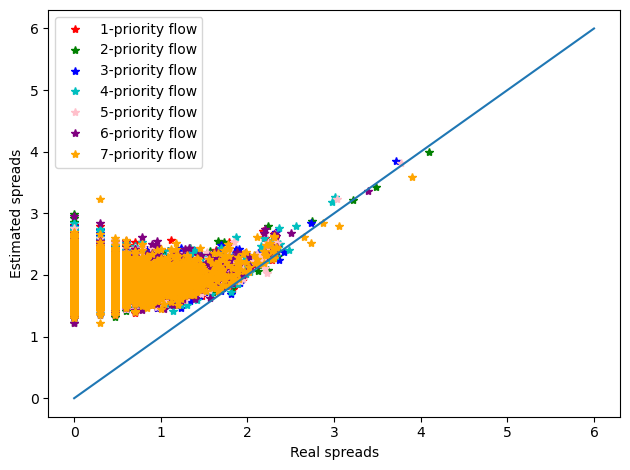

In [13]:
x1 = np.arange(0, 7,1)
y1 = x1
for i in range(1, max_priority + 1):
    plt.plot(np.log10(x_dict[i]), np.log10(y_dict[i]), "*", color = color_lst[i - 1], label = str(i) + "-priority flow")
plt.plot(x1, y1)
plt.legend()
plt.xlabel("Real spreads")
plt.ylabel("Estimated spreads")
plt.tight_layout()
plt.savefig("vHLL.jpg")
plt.show()

In [14]:
np.mean(abs((x-y)/x))

68.49724972373009

In [15]:
ratio_ = 0.0
for i in range(len(x)):
    ratio_ += max(x[i] / y[i], y[i] / x[i])
print(ratio_ / len(x))

69.49725308263724


In [16]:
np.mean(abs(x-y))

75.98632138368431

In [17]:
data = list()

for i in range(len(x)):
    data.append(str(x[i]) + " " + str(y[i]) + "\n")
    
data = list(set(data))
print(len(data))

13246
